In [1]:
%matplotlib inline
import collections
import sys
import subprocess
import pandas as pd
import os
import numpy as np
import uuid
import tempfile
import bnpy
import scikit_posthocs as sp
import itertools
import seaborn as sns
import matplotlib.pyplot as plt


from scipy.stats import kruskal, f_oneway
from scipy.stats import ttest_ind

sys.path.append('/opt/hydra/')
src = os.environ["HYDRA_SRC"]

import library.analysis as hy
from library.fit import subprocess_fit

In [7]:
exp_path = '../data/treehouse-ewing-log2TPM1-V9.tsv'
mm_genes = '../data/ewing-output/MultiModalGenes'

In [8]:
exp = pd.read_csv(exp_path, sep='\t', index_col=0)

(16352, 82)

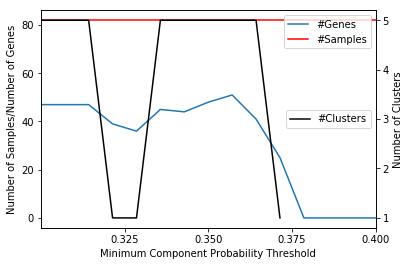

In [9]:
# Scan min probability thresholds
run_scan = False
if run_scan:
    scan = hy.ScanEnrichmentAnalysis(mm_genes, 
                                     exp_path, 
                                     'GO', 
                                     min_prob_range=np.linspace(0.3, 0.4, 15), 
                                     CPU=7,
                                     K=5).scan()

In [11]:
# Apply EnrichmentAnalysis
res = hy.EnrichmentAnalysis(exp_path=exp_path,
                            mm_path=mm_genes,
                            min_prob_filter=0.364286,
                            gmt_path='GO')

In [12]:
genes = res.get_enriched_term_genes()
len(genes)

41

In [13]:
# Apply multivariate DP-GMM model
clus = hy.MultivariateMixtureModel(data=exp.reindex(genes),
                                   center=True,
                                   gamma=5.0,
                                   variance=2.0,
                                   K=5, 
                                   verbose=True)

centering data


In [14]:
# Get cluster assignments
assignments = clus.get_assignments(exp.reindex(genes))

assign = pd.DataFrame(index=exp.columns,
                      columns=[1])

for sample, assignment in zip(exp.columns, assignments):
    assign.loc[sample, 1] = assignment + 1

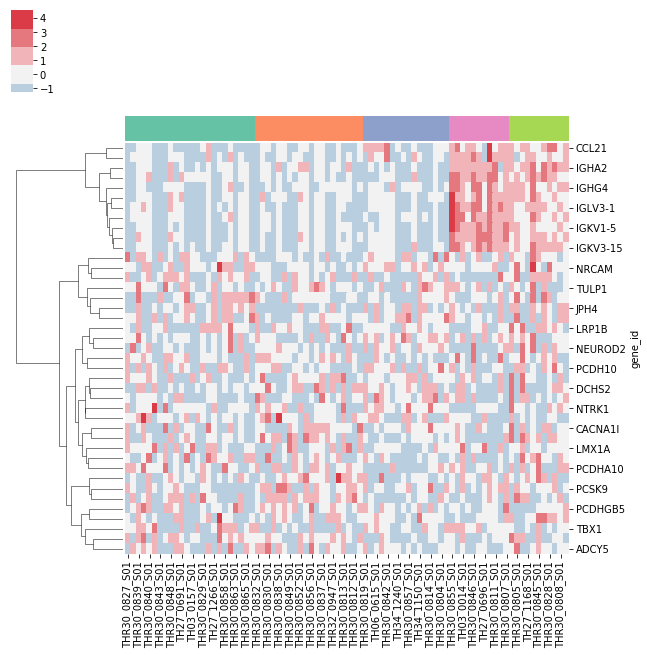

In [15]:
# Plot expression heatmap
col_order = assign.sort_values(1).index.values
cmap = sns.color_palette("Set2", max(assign[1].values))
col_colors = [cmap[x - 1] for x in assign.sort_values(1)[1].values]

g = sns.clustermap(exp.reindex(genes).reindex(col_order, axis=1),
                   col_cluster=False,
                   col_colors=col_colors,
                   z_score=0,
                   method='ward',
                   center=0,
                   cmap=sns.diverging_palette(240, 10, n=7),
                   figsize=(10, 10))

ax = g.ax_heatmap

In [16]:
def format_pathway(x):
    """
    Create a more readable pathway name
    """
    fields = x.split('%')
    return '%s (%s)' % (fields[0], fields[1])

In [17]:
# Apply GSEA to each cluster
fgsea = clus.get_cluster_features(exp, 
                                  gmt='/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt')

In [20]:
# Save the enriched gene sets for each cluster
fgsea_df = None
for key, values in fgsea.items():
    if fgsea_df is None:
        header = pd.MultiIndex.from_product([list(fgsea.keys()), 
                                             ['padj', 'NES']],
                                           names=['cluster', 'feature'])
        
        fgsea_df = pd.DataFrame(index=values.index.values, columns=header)
        
    #print 'Key: ', key,
    t = values.reset_index().reindex(['pathway', 'padj', 'NES'], axis=1)
    t['pathway'] = t['pathway'].apply(format_pathway) 
    #print(t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10))
    
    fgsea_df[(key, 'padj')] = values.loc[fgsea_df.index, 'padj'].values
    fgsea_df[(key, 'NES')] = values.loc[fgsea_df.index, 'NES'].values

In [21]:
# Save enriched pathways for downstream analysis
pth = '../data/TH-Ewing-Pathways-Enrichment.tsv'
fgsea_df.to_csv(pth, sep='\t')

In [22]:
pth = '../img/TH-Ewing-top-10-pathways-cluster-%d.tex'
for key, values in fgsea.items():
    with pd.option_context('display.precision', 2):
        t = values.reset_index().reindex(['pathway', 'padj', 'NES'], axis=1)
        t['pathway'] = t['pathway'].apply(format_pathway)
        with open(pth % key, 'w') as f:
            #print(t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10).to_latex(index=False))
            t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10).to_latex(f, index=False)

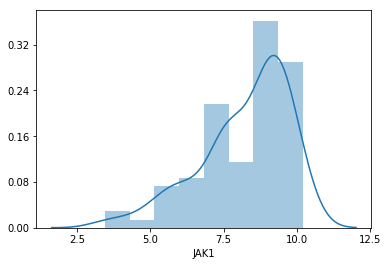

In [23]:
# Investigate 

sns.distplot(exp.loc['JAK1', :])

In [24]:
jak1 = pd.DataFrame(index=['JAK1'],
                    columns=exp.columns)

jak1.loc['JAK1', :] = exp.loc['JAK1', :].values

In [25]:
import uuid
import bnpy

data = exp.loc['JAK1', :].values
data = data - np.mean(data)
data = data.reshape(len(data), 1)

xdata = bnpy.data.XData(data)

gamma = 5.0
sF = 1.0
K = 25

jak1_model, _ = bnpy.run(
    xdata, 'DPMixtureModel', 'Gauss', 'memoVB',
    output_path=('/tmp/%s/' % uuid.uuid4() +
        'trymoves-K=%d-gamma=%s-ECovMat=%s*eye-moves=merge,shuffle/' % (
            K, gamma, sF)),
    nLap=1000, nTask=1, nBatch=1,
    gamma0=gamma, sF=sF, ECovMat='eye',
    K=K, initname='randexamplesbydist',
    moves='birth,merge,delete,shuffle',
    b_startLap=10,
    m_startLap=10,
    d_startLap=20)

Dataset Summary:
X Data
  total size: 82 units
  batch size: 82 units
  num. batches: 1
Allocation Model:  DP mixture with K=0. Concentration gamma0= 5.00
Obs. Data  Model:  Gaussian with full covariance.
Obs. Data  Prior:  Gauss-Wishart on mean and covar of each cluster
  E[  mean[k] ] = 
   [0.] 
  E[ covar[k] ] = 
  [[1.]]
Initialization:
  initname = randexamplesbydist
  K = 25 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/ac18900d-83c9-4060-b695-059d8afbcf3c/trymoves-K=25-gamma=5.0-ECovMat=1.0*eye-moves=merge,shuffle/1
BIRTH @ lap 1.00: Disabled. Waiting for lap >= 10 (--b_startLap).
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
DELETE @ lap 1.00: Disabled. Cannot delete before first complete lap, because SS that represents whole dataset is required.
    1.000/1000 after      0 sec. |    224.5 MiB | K   25 | 

BIRTH @ lap 25.000 : None attempted. 3 past failures. 0 too small. 0 too busy.
   25.000/1000 after      3 sec. |    224.6 MiB | K    3 | loss  2.076854464e+00 | Ndiff    0.001 
MERGE @ lap 26.00: No promising candidates, so no attempts.
BIRTH @ lap 26.000 : None attempted. 0 past failures. 0 too small. 3 too busy.
DELETE @ lap 26.00: 0/1 accepted. Ndiff 0.00.
   26.000/1000 after      3 sec. |    224.6 MiB | K    3 | loss  2.076854462e+00 | Ndiff    0.001 
MERGE @ lap 27.00: No promising candidates, so no attempts.
BIRTH @ lap 27.000 : None attempted. 0 past failures. 0 too small. 3 too busy.
DELETE @ lap 27.00: 0/1 accepted. Ndiff 0.00.
   27.000/1000 after      3 sec. |    224.6 MiB | K    3 | loss  2.076854461e+00 | Ndiff    0.000 
MERGE @ lap 28.00: No promising candidates, so no attempts.
BIRTH @ lap 28.000 : None attempted. 0 past failures. 0 too small. 3 too busy.
DELETE @ lap 28.00: 0/1 accepted. Ndiff 0.00.
   28.000/1000 after      3 sec. |    224.6 MiB | K    3 | loss  2.07

In [26]:
def get_assignments(model, data):
    """
    Takes model and data and classifies samples

    Will label samples with NaN if they do not
    fit in any of the model components

    :param model:
    :param data:
    :return:
    """
    unclass = 1 - np.sum(model.allocModel.get_active_comp_probs())
    # Get the sample assignments
    LP = model.calc_local_params(data)
    asnmts = []
    for row in range(LP['resp'].shape[0]):
        _max = np.max(LP['resp'][row, :])
        if _max < unclass:
            asnmts.append(np.nan)

        else:
            _arg = np.argmax(LP['resp'][row, :])
            asnmts.append(_arg)

    return asnmts

In [27]:
jak1_assignments = get_assignments(jak1_model, xdata)

In [28]:
jak1_assign = pd.DataFrame(index=exp.columns,
                           columns=[0])

for sample, assignment in zip(exp.columns, jak1_assignments):
    jak1_assign.loc[sample, 0] = assignment

In [30]:
pth = '../data/xCell_treehouse-ewing-log2TPM1-V9_xCell_1952062819.txt'
xcell = pd.read_csv(pth, sep='\t', index_col=0)
xcell.columns = [x.replace('.', '-') for x in xcell.columns]

In [31]:
data = pd.DataFrame(columns=['sample', 'cluster', 'source', 'feature', 'value'])
for sample in jak1_assign.index.values:
        
    assignment = jak1_assign.loc[sample, 0]
    
    if pd.isnull(assignment):
        continue
    
    for cell, value in xcell[sample].iteritems():
        data.loc[len(data), :] = [sample, assignment, 'xCell', cell, value]
        
skip = ['P-value', 'Pearson Correlation', 'RMSE']

data = data[~data['feature'].isin(skip)]
        
data['value'] = pd.to_numeric(data['value'])

In [32]:
import collections
from scipy.stats import kruskal
import scikit_posthocs as sp
import itertools

sigs = collections.defaultdict(list)

p_values = pd.DataFrame(columns=['source', 
                                 'feature', 
                                 'A', 
                                 'B', 
                                 'holm p-value'])

for source, rows in data.groupby('source'):
    #print(source)
    #print()
    nfeatures = len(rows['feature'].unique())
    alpha = 1 - (1 - 0.05) ** (1.0 / nfeatures)
    #print(alpha)
    for feature in rows['feature'].unique():
        print(feature)
        groups3 = []
        for i, rows in data[data['feature'] == feature].groupby('cluster'):
            groups3.append(list(rows['value'].values))
            print i, rows['value'].mean()
    
        try:
            stat, pvalue = kruskal(*groups3)
            print(feature, pvalue, pvalue < alpha)
        
        except:
            print 'failed'
            continue
    
        if pvalue < alpha:
            sigs[source].append(feature)
            
            try:
                res = sp.posthoc_mannwhitney(groups3, 
                                             p_adjust='holm')
                
            except ValueError:
                continue
            
            for i, j in itertools.combinations(range(len(groups3)),
                                               2):
                
                if i == j:
                    continue 
                    
                p_values.loc[len(p_values), :] = [source,
                                                  feature,
                                                  i, 
                                                  j,
                                                  res.iloc[i, j]]

Adipocytes
0 0.0037063829787234042
1 0.008979999999999998
2 0.00202
('Adipocytes', 0.05008470762831077, False)
Astrocytes
0 0.00375531914893617
1 0.029054999999999997
2 0.02255333333333333
('Astrocytes', 3.2495629521250496e-05, True)
B-cells
0 0.0017617021276595745
1 0.0037400000000000003
2 0.021720000000000003
('B-cells', 0.0001321116287260405, True)
Basophils
0 0.16993191489361706
1 0.14456000000000002
2 0.05590000000000001
('Basophils', 0.0010644837623293541, False)
CD4+ T-cells
0 0.0
1 0.0
2 7.333333333333333e-05
('CD4+ T-cells', 0.1071705987523412, False)
CD4+ Tcm
0 0.007253191489361701
1 0.00419
2 0.0034733333333333335
('CD4+ Tcm', 0.747145862412715, False)
CD4+ Tem
0 0.0023
1 0.00011
2 0.0064266666666666665
('CD4+ Tem', 0.21135961854674162, False)
CD4+ memory T-cells
0 0.0
1 0.0017100000000000001
2 0.005026666666666666
('CD4+ memory T-cells', 0.002815886615888342, False)
CD4+ naive T-cells
0 0.0007702127659574468
1 0.0
2 0.0024
('CD4+ naive T-cells', 0.0060840553090407866, False

In [33]:
print jak1_model.obsModel.get_mean_for_comp(0)
print jak1_model.obsModel.get_mean_for_comp(1)
print jak1_model.obsModel.get_mean_for_comp(2)

[1.07756991]
[-0.57676203]
[-2.54844881]


In [34]:
data.loc[data['cluster'] == 0, 'reorder'] = 2
data.loc[data['cluster'] == 1, 'reorder'] = 1
data.loc[data['cluster'] == 2, 'reorder'] = 0
data['reorder'] = data['reorder'].astype(int)

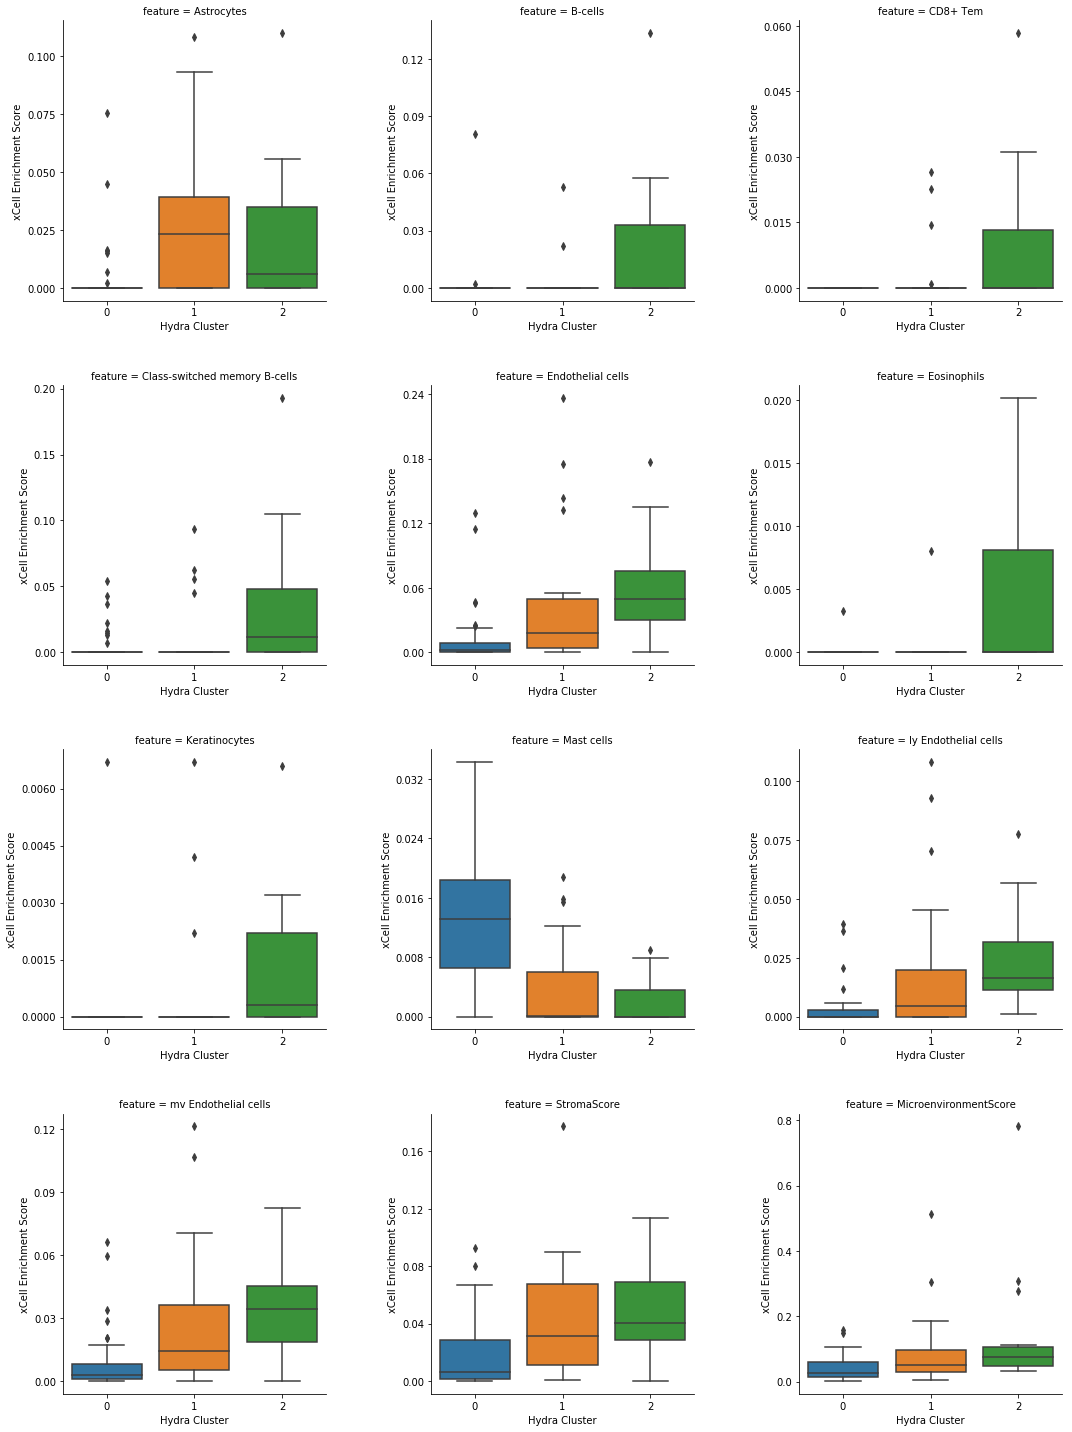

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

mask = (data['source'] == 'xCell') & (data['feature'].isin(sigs['xCell']))

t = data[mask]

g = sns.catplot(x='cluster', 
                y='value', 
                col='feature',
                kind='box',
                col_wrap=3,
                sharex=False,
                sharey=False,
                data=t)

for i in range(len(g.axes)):
    g.axes[i].set_xlabel('Hydra Cluster')
    g.axes[i].set_ylabel('xCell Enrichment Score')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

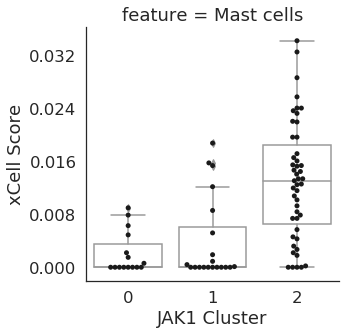

In [36]:
sns.set(font_scale=1.5, style='white')

interest = ["Mast cells"]

mask = (data['source'] == 'xCell') & (data['feature'].isin(interest))

t = data[mask]

g = sns.catplot(x='reorder', 
                y='value', 
                col='feature',
                kind='box',
                col_wrap=3,
                col_order=interest,
                color='white',
                sharex=False,
                sharey=False,
                data=t)

# CD8+
sns.swarmplot(x='reorder',
              y='value',
              color='k',
              size=5,
              data=t[t['feature'] == 'Mast cells'],
              ax=g.axes[0])

for i in range(len(g.axes)):
    g.axes[i].set_xlabel('JAK1 Cluster')
    g.axes[i].set_ylabel('xCell Score')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

pth = '../img/xCell-mast-cell-plot.png'
plt.savefig(pth, format='png', bbox_inches='tight')

pth = '../img/xCell-mast-cell-plot.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

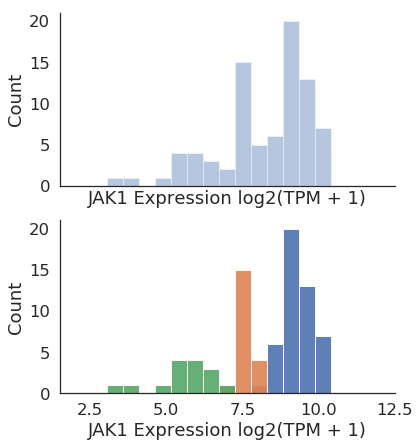

In [38]:
fig, axes = plt.subplots(2, 1, 
                         figsize=(6, 7),
                         sharex=True)

bins = np.linspace(2, 12, 20)
sns.distplot(exp.loc['JAK1', :],
            kde=False,
            bins=bins,
            ax=axes[0])

sns.distplot(exp.loc['JAK1', jak1_assign[jak1_assign[0] == 0].index],
             bins=bins,
             kde=False,
             ax=axes[1],
             hist_kws={'alpha': 0.9})
sns.distplot(exp.loc['JAK1', jak1_assign[jak1_assign[0] == 1].index],
             bins=bins,
             kde=False,
             ax=axes[1],
             hist_kws={'alpha': 0.9})
sns.distplot(exp.loc['JAK1', jak1_assign[jak1_assign[0] == 2].index],
             bins=bins,
             kde=False,
             ax=axes[1],
             hist_kws={'alpha': 0.9})


axes[0].set_ylabel('Count')
axes[1].set_ylabel('Count')

axes[0].set_xlabel('JAK1 Expression log2(TPM + 1)')
axes[1].set_xlabel('JAK1 Expression log2(TPM + 1)')

sns.despine()

pth = '../img/jak1-expression-plot.png'
plt.savefig(pth, format='png', bbox_inches='tight')

pth = '../img/jak1-expression-plot.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')